In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils_contributions import *
import torch.nn.functional as F
from contributions import ModelWrapper, ClassificationModelWrapperCaptum, LMModelWrapperCaptum, interpret_sentence_sv
import pandas as pd

# from functools import partial
# import collections
import torch.nn as nn
import random
random.seed(10)

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.set_device(1)
torch.cuda.current_device()

1

# Subject-verb agreement

In [2]:
model_name = 'distilbert'

model, tokenizer, dataset_partition = load_model_data(model_name)

Loading distilbert ...
Loading None ...


In [21]:
num_sentences = 4000#3,4000,10,28
for i,line in enumerate(open("lgd_dataset.tsv",encoding="utf8")):
    na,_,masked,good,bad = line.strip().split("\t")
    if model_name == 'roberta':
        good = '\u0120' + good
        bad = '\u0120' + bad
    if i == num_sentences:
        break

### Tokenize text

In [22]:
text = masked.replace('***mask***',tokenizer.mask_token)
print(text)
pt_batch = tokenizer(text, return_tensors="pt").to(device)
target_idx = (pt_batch['input_ids'][0] == tokenizer.mask_token_id).nonzero(as_tuple=True)
target_idx = target_idx[0].item()
tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
print(tokenized_text)
good_verb_id = tokenizer.convert_tokens_to_ids(good)
wrong_verb_id = tokenizer.convert_tokens_to_ids(bad)
print('correct verb:', good, good_verb_id)


certainly the tracks listed on the chart all [MASK] to be very obscure .
['[CLS]', 'certainly', 'the', 'tracks', 'listed', 'on', 'the', 'chart', 'all', '[MASK]', 'to', 'be', 'very', 'obscure', '.', '[SEP]']
correct verb: seem 4025


## Forward pass

In [23]:
model_wrapped = ModelWrapper(model)
prediction_scores, hidden_states, attentions, transformed_vectors_norm_model, contributions, _ = model_wrapped(pt_batch)
probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
pred_ind = torch.argmax(probs[0][target_idx])
print(pred_ind)
pred = torch.max(probs[0][target_idx])
print('predicted token', tokenizer.convert_ids_to_tokens(pred_ind.item()))
print('probability of highest predicted token', pred)

tensor(3711, device='cuda:1')
predicted token appear
probability of highest predicted token tensor(0.4433, device='cuda:1')


In [24]:
## probability of correct verb
probs[0,target_idx,good_verb_id]

tensor(0.3702, device='cuda:1')

torch.Size([16, 16, 30522])
torch.Size([16])


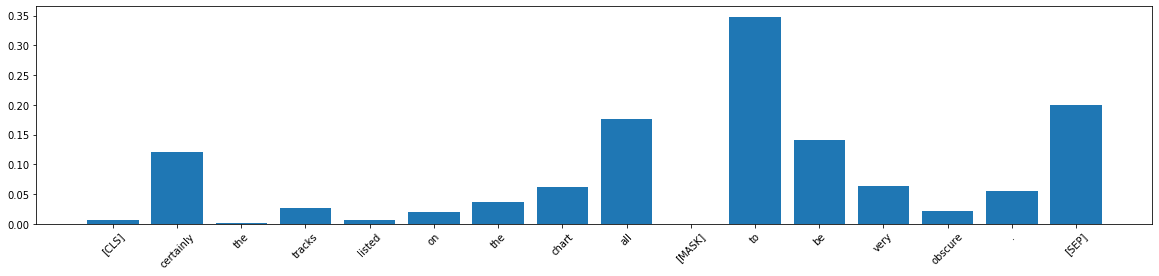

In [25]:
model_wrapped = ModelWrapper(model)
prediction_scores, hidden_states, attentions, transformed_vectors_norm_model, contributions, _ = model_wrapped(pt_batch)
probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
actual_verb_score = probs[0][target_idx][good_verb_id]
inflected_verb_score = probs[0][target_idx][wrong_verb_id]

main_diff_score = actual_verb_score - inflected_verb_score

# Repeating examples and replacing one token at a time with unk
batch_size = 1
max_len = pt_batch['input_ids'][0].size(0)

# Repeat each example 'max_len' times
x = pt_batch['input_ids'].cpu().detach().numpy()
extended_x = np.reshape(np.tile(x[:,None,...], (1, max_len, 1)),(-1,x.shape[-1]))

# Create unk sequences and unk mask
unktoken = tokenizer.encode([tokenizer.mask_token])[1]
unks = unktoken * np.eye(max_len)
unks =  np.tile(unks, (batch_size, 1))

unk_mask =  (unktoken - unks)/unktoken

# Replace one token in each repeatition with unk
extended_x = extended_x * unk_mask + unks

# Get the new output
extended_logits = model_wrapped.get_prediction(torch.tensor(extended_x, dtype=torch.int64,device=device))
# extended_logits = extended_predictions[0]
extended_probs = torch.nn.Softmax(dim=-1)(extended_logits)
print(extended_probs.size())
extended_correct_probs = extended_probs[:,target_idx,good_verb_id]
print(extended_correct_probs.size())
# extended_wrong_probs =  extended_probs[:,target_idx,wrong_verb_id]
# extended_diff_scores = extended_correct_probs - extended_wrong_probs


# # Save the difference in the probability predicted for the correct class
#diffs = abs(main_diff_score - extended_diff_scores)
diffs = abs(actual_verb_score - extended_correct_probs)

plot_histogram(diffs,tokenized_text)

### Getting attention weights (attentions_mat), attention vector norms (model_norms) and contributions from our method (contributions)

In [26]:
_attentions = [att.detach().cpu().numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0] # (num_layers,num_heads,src_len,src_len)
att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
print(att_mat_sum_heads.shape)
normalized_model_norms = normalize_contributions(transformed_vectors_norm_model,scaling='sum_one')
normalized_contributions = normalize_contributions(contributions,scaling='min_sum')#min_sum


(6, 16, 16)


### Rollout with attention weights (Abnar and Zuidema, 2020)

In [27]:
joint_attentions = compute_rollout(att_mat_sum_heads)


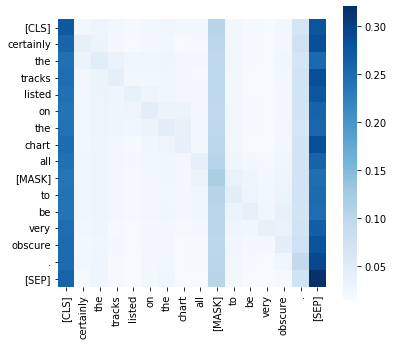

In [28]:
layer = -1
plt.figure(figsize=(6,6))
df = pd.DataFrame(joint_attentions[layer].cpu().detach().numpy(),columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

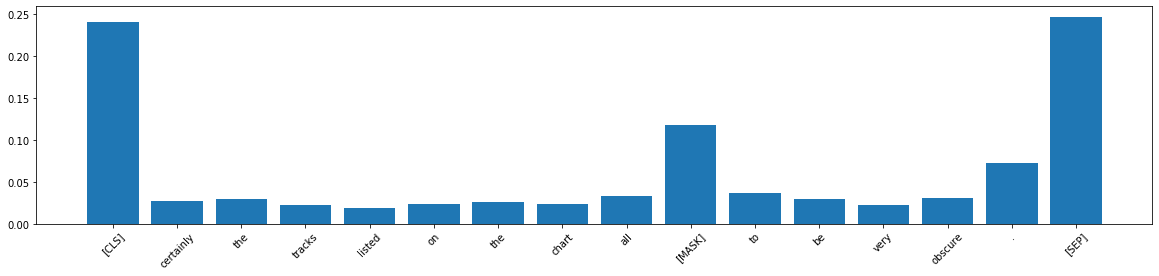

In [29]:
joint_attention_layer = -1
pos = target_idx
joint_attentions_cls = joint_attentions[joint_attention_layer][pos]
plot_histogram(joint_attentions_cls,tokenized_text)

### Attention rollout + (Vector Norms T(x_j + RES + LN)) (Kobayashi et al., 2021)

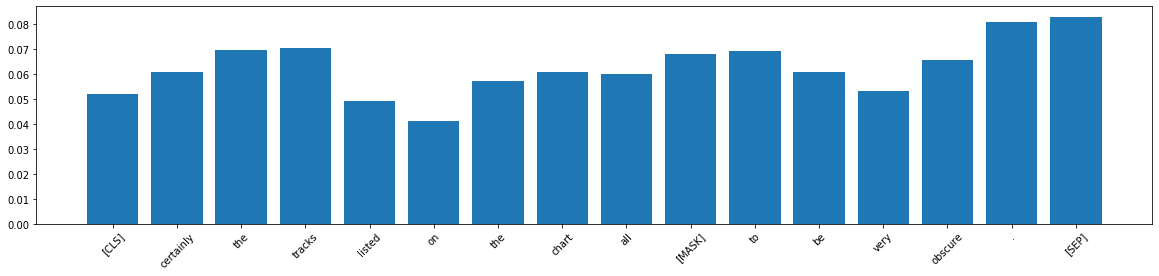

In [30]:
norms_mix = compute_joint_attention(normalized_model_norms)
joint_attention_layer = -1
pos = target_idx
norms_mix_cls = norms_mix[joint_attention_layer][pos]
plot_histogram(norms_mix_cls,tokenized_text)

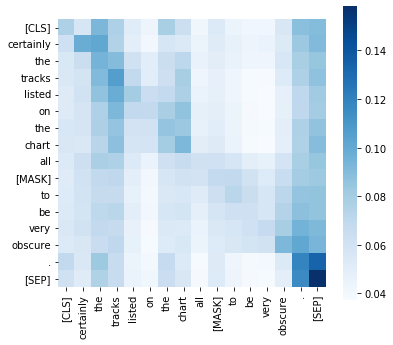

In [31]:

norms_mix = norms_mix.detach().cpu().numpy()
plt.figure(figsize=(6,6))
joint_attention_layer = -1
df = pd.DataFrame(norms_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)


### Our approach

torch.float32


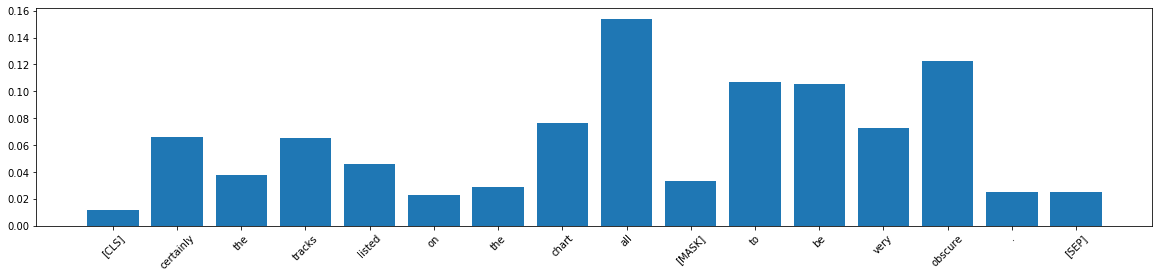

In [32]:
print(normalized_contributions.dtype)
contributions_mix = compute_joint_attention(normalized_contributions)
joint_attention_layer = -1
pos = target_idx
contributions_mix_cls = contributions_mix[joint_attention_layer][pos]
plot_histogram(contributions_mix_cls,tokenized_text)

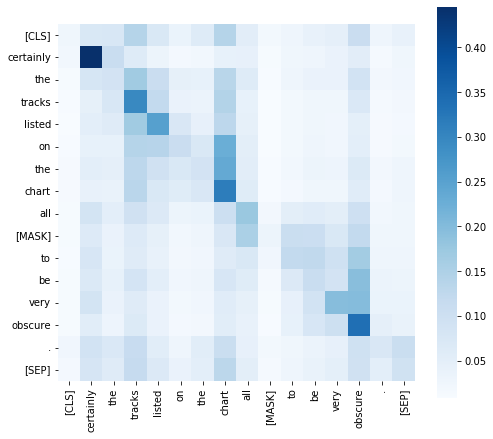

In [33]:
contributions_mix = contributions_mix.detach().cpu().numpy()
plt.figure(figsize=(8,8))

#joint_attention_normalized_layer = contributions_mix[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]
df = pd.DataFrame(contributions_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)


In [34]:
# try:
#     num_layers = model.config.num_hidden_layers
# except:
#     num_layers = model.config.n_layers

# if num_layers == 12:
#     fig, axs = plt.subplots(3, 4,figsize=(25,19),sharey=False)
#     row = 4
#     col = 4
# elif num_layers == 6:
#     fig, axs = plt.subplots(2, 3,figsize=(20,13),sharey=False)
#     row = 3
#     col = 3

# for layer in range(0,num_layers):
#     df = pd.DataFrame(contributions_mix[layer],columns=tokenized_text,index=tokenized_text)
#     sns.heatmap(df,cmap="Blues",square=True,ax=axs[int(layer/row),layer%col],cbar_kws={'shrink': 0.8})
#     axs[int(layer/row),layer%col].set_title('Layer ' + str(layer))
#     axs[int(layer/row),layer%col].tick_params(axis='x', rotation=90)
#     plt.gcf().subplots_adjust(bottom=0.2)

## Other attribution methods with Captum

In [35]:
## https://github.com/pytorch/captum/issues/150

bert_model_wrapper = LMModelWrapperCaptum(model)

grad_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='grad', mask_pos=target_idx, label=pred_ind)
grad_input_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='grad_input', mask_pos=target_idx, label=pred_ind)
grad_ig_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='ig', mask_pos=target_idx, label=pred_ind)


In [36]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def add_attributions_to_visualizer(attributions, tokens, label, vis_data_records):
    pred = 1
    attributions_min_max = normalize_attribution_visualization(attributions)
    attributions_min_max = attributions_min_max.cpu().detach().numpy()

    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions_min_max,
                            pred,
                            label,
                            label,
                            "label",
                            attributions_min_max.sum(),       
                            tokens[:len(attributions_min_max)],
                            0))
    return attributions_min_max

tokens = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0].cpu().detach().numpy().tolist())
min_max_grad_attributions = add_attributions_to_visualizer(grad_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_grad_input_attributions = add_attributions_to_visualizer(grad_input_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_grad_ig_attributions = add_attributions_to_visualizer(grad_ig_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_contributions_mix_cls = add_attributions_to_visualizer(contributions_mix_cls, tokens, pred_ind, vis_data_records_ig)
visualization.visualize_text(vis_data_records_ig);

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3711,3711 (1.00),label,5.66,[CLS] certainly the tracks listed on the chart all [MASK] to be very obscure . [SEP]
3711,3711 (1.00),label,3.51,[CLS] certainly the tracks listed on the chart all [MASK] to be very obscure . [SEP]
3711,3711 (1.00),label,2.23,[CLS] certainly the tracks listed on the chart all [MASK] to be very obscure . [SEP]
3711,3711 (1.00),label,5.69,[CLS] certainly the tracks listed on the chart all [MASK] to be very obscure . [SEP]


## Prepare paper saliency map tables

In [37]:
attributions_list = []
attributions_list.append(min_max_grad_attributions)
attributions_list.append(min_max_grad_input_attributions)
attributions_list.append(min_max_grad_ig_attributions)
attributions_list.append(min_max_contributions_mix_cls)
prepare_colorize()
figure_saliency(attributions_list, tokenized_text)

## Correlation between methods

In [3]:
num_samples = 500

In [4]:

layer = -1
all_examples_raw_relevance = {}
all_examples_raw_relevance[layer] = []

all_examples_rollout_relevance = {}
all_examples_rollout_relevance[layer] = []

all_examples_norms_mix_relevance = {}
all_examples_norms_mix_relevance[layer] = []

all_examples_contributions_mix_relevance = {}
all_examples_contributions_mix_relevance[layer] = []

all_examples_blankout_relevance = []

all_examples_x = []

data_file = open("lgd_dataset.tsv",encoding="utf8")
data_file_list = data_file.readlines()

# Random samples from test set (no duplicates)
random.seed(10)
random_samples_list = random.sample(range(len(data_file_list)), num_samples)

#for i,line in enumerate(open("lgd_dataset.tsv",encoding="utf8")):
for i in random_samples_list:
    #na,_,masked,good,bad = line.strip().split("\t")
    na,_,masked,good,bad = data_file_list[i].strip().split("\t")
    if i == num_samples:
        break
    # Add Ġ to word if using RoBERTa
    if model_name == 'roberta':
        good = '\u0120' + good
        bad = '\u0120' + bad
    text = masked.replace('***mask***',tokenizer.mask_token)
    pt_batch = tokenizer(text, return_tensors="pt").to(device)
    target_idx = (pt_batch['input_ids'][0] == tokenizer.mask_token_id).nonzero(as_tuple=True)
    target_idx = target_idx[0].item()
    good_verb_id = tokenizer.convert_tokens_to_ids(good)
    wrong_verb_id = tokenizer.convert_tokens_to_ids(bad)
    
    model_wrapped = ModelWrapper(model)
    prediction_scores, hidden_states, attentions, transformed_vectors_norm_model, contributions, _ = model_wrapped(pt_batch)
    all_examples_x.append(pt_batch["input_ids"][0])

   
    probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
    actual_verb_score = probs[0][target_idx][good_verb_id]
    inflected_verb_score = probs[0][target_idx][wrong_verb_id]

    main_diff_score = actual_verb_score - inflected_verb_score

    # Raw attentions relevances    
    _attentions = [att.detach().cpu().numpy() for att in attentions]
    attentions_mat = np.asarray(_attentions)[:,0]
    raw_attn_relevances = get_raw_att_relevance(attentions_mat,token_pos=target_idx)
    # raw_attn_relevances = np.delete(raw_attn_relevances,target_idx)
    # raw_attn_relevances = raw_attn_relevances[1:-1]
    all_examples_raw_relevance[layer].append(np.asarray(raw_attn_relevances))

    # Rollout attentions relevances
    att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
    joint_attentions = compute_rollout(att_mat_sum_heads)
    rollout_relevance_relevances = joint_attentions[layer][target_idx]
    # rollout_relevance_relevances = torch.cat((rollout_relevance_relevances[:target_idx], rollout_relevance_relevances[target_idx+1:]))
    # rollout_relevance_relevances = rollout_relevance_relevances[1:-1]
    all_examples_rollout_relevance[layer].append(np.asarray(rollout_relevance_relevances))

    # Normalized model norms + roll out relevances
    normalized_model_norms = normalize_contributions(transformed_vectors_norm_model,scaling='sum_one')
    norms_mix = compute_joint_attention(normalized_model_norms)
    norms_mix_relevances = norms_mix[layer][target_idx]
    # norms_mix_relevances = torch.cat((norms_mix_relevances[:target_idx], norms_mix_relevances[target_idx+1:]))
    # norms_mix_relevances = norms_mix_relevances[1:-1]
    all_examples_norms_mix_relevance[layer].append(np.asarray(norms_mix_relevances))

    # Our method relevances
    normalized_contributions = normalize_contributions(contributions,scaling='min_sum')#min_sum
    contributions_mix = compute_joint_attention(normalized_contributions)
    contributions_mix_relevances = contributions_mix[layer][target_idx]
    # contributions_mix_relevances = torch.cat((contributions_mix_relevances[:target_idx], contributions_mix_relevances[target_idx+1:]))
    # contributions_mix_relevances = contributions_mix_relevances[1:-1]
    all_examples_contributions_mix_relevance[layer].append(np.asarray(contributions_mix_relevances))

    # Blank-out
    main_diff_score = actual_verb_score - inflected_verb_score

    # Repeating examples and replacing one token at a time with unk
    batch_size = 1
    max_len = pt_batch['input_ids'][0].size(0)

    # Repeat each example 'max_len' times
    x = pt_batch['input_ids'].cpu().detach().numpy()
    extended_x = np.reshape(np.tile(x[:,None,...], (1, max_len, 1)),(-1,x.shape[-1]))

    # Create unk sequences and unk mask
    unktoken = tokenizer.encode([tokenizer.mask_token])[1]
    unks = unktoken * np.eye(max_len)
    unks =  np.tile(unks, (batch_size, 1))

    unk_mask =  (unktoken - unks)/unktoken

    # Replace one token in each repeatition with unk
    extended_x = extended_x * unk_mask + unks

    # Get the new output
    extended_logits = model_wrapped.get_prediction(torch.tensor(extended_x, dtype=torch.int64, device=device))
    # extended_logits = extended_predictions[0]
    extended_probs = torch.nn.Softmax(dim=-1)(extended_logits)
    extended_correct_probs = extended_probs[:,target_idx,good_verb_id]
    # extended_wrong_probs =  extended_probs[:,target_idx,wrong_verb_id]
    # extended_diff_scores = extended_correct_probs - extended_wrong_probs

    # # Save the difference in the probability predicted for the correct class
    #diffs = abs(main_diff_score - extended_diff_scores)
    diffs = abs(actual_verb_score - extended_correct_probs)

    all_examples_blankout_relevance.append(diffs.cpu().detach().numpy())

    

In [5]:
l = layer
print("############### Layer ",l, "#############")
print('raw vs blank-out')
print(all_examples_raw_relevance[l][0].shape, all_examples_blankout_relevance[0].shape)
raw_sps_grad = []
for i in np.arange(len(all_examples_x)):
    sp = spearmanr(all_examples_raw_relevance[l][i],all_examples_blankout_relevance[i])
    raw_sps_grad.append(sp[0])

    
print(np.mean(raw_sps_grad), np.std(raw_sps_grad))

print('rollout vs blank-out')
print(all_examples_rollout_relevance[l][0].shape, all_examples_blankout_relevance[0].shape)
joint_sps_grad = []
for i in np.arange(len(all_examples_x)):
    sp = spearmanr(all_examples_rollout_relevance[l][i],all_examples_blankout_relevance[i])
    joint_sps_grad.append(sp[0])

print(np.mean(joint_sps_grad), np.std(joint_sps_grad))


print('kob norms vs blank-out')
print(all_examples_norms_mix_relevance[l][0].shape, all_examples_blankout_relevance[0].shape)
joint_sps_grad = []
for i in np.arange(len(all_examples_x)):
    sp = spearmanr(all_examples_norms_mix_relevance[l][i],all_examples_blankout_relevance[i])
    joint_sps_grad.append(sp[0])

print(np.mean(joint_sps_grad), np.std(joint_sps_grad))

print('ours vs blank-out')
print(all_examples_contributions_mix_relevance[l][0].shape, all_examples_blankout_relevance[0].shape)
joint_sps_grad = []
for i in np.arange(len(all_examples_x)):
    sp = spearmanr(all_examples_contributions_mix_relevance[l][i],all_examples_blankout_relevance[i])
    joint_sps_grad.append(sp[0])

    
print(np.mean(joint_sps_grad), np.std(joint_sps_grad))

############### Layer  -1 #############
raw vs blank-out
(24,) (24,)
0.17341189279206584 0.1964844874301405
rollout vs blank-out
(24,) (24,)
-0.09158077367051747 0.22023676835298653
kob norms vs blank-out
(24,) (24,)
0.08381913636587045 0.2226121290498114
ours vs blank-out
(24,) (24,)
0.4444513741131352 0.17947604156049124


In [9]:
all_examples_grads = []
#all_examples_grad_relevance[layer] = []
for i,line in enumerate(open("lgd_dataset.tsv",encoding="utf8")):
    na,_,masked,good,bad = line.strip().split("\t")
    if i == num_samples:
        break
        # Add Ġ to word if using RoBERTa
    if model_name == 'roberta':
        good = '\u0120' + good
        bad = '\u0120' + bad
    text = masked.replace('***mask***',tokenizer.mask_token)
    pt_batch = tokenizer(text, return_tensors="pt").to(device)
    target_idx = (pt_batch['input_ids'][0] == tokenizer.mask_token_id).nonzero(as_tuple=True)
    target_idx = target_idx[0].item()
    good_verb_id = tokenizer.convert_tokens_to_ids(good)
    #wrong_verb_id = tokenizer.convert_tokens_to_ids(bad)

    bert_model_wrapper = LMModelWrapperCaptum(model)
    #ig = IntegratedGradients(bert_model_wrapper)
    saliency = Saliency(bert_model_wrapper)

    grad_relevance, _ = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='grad_input', mask_pos=target_idx, label=good_verb_id).cpu().detach().numpy()
    # grad_relevance = np.delete(grad_relevance,target_idx)
    # grad_relevance = grad_relevance[1:-1]
    all_examples_grads.append(grad_relevance)

AttributeError: 'tuple' object has no attribute 'cpu'

In [24]:
l = layer
print("############### Layer ",l, "#############")
print('raw vs grad')
print(all_examples_raw_relevance[l][0].shape, all_examples_grads[0].shape)
raw_sps_grad = []
for i in np.arange(len(all_examples_x)):
    sp = spearmanr(all_examples_raw_relevance[l][i],all_examples_grads[i])
    raw_sps_grad.append(sp[0])

    
print(np.mean(raw_sps_grad), np.std(raw_sps_grad))

print('rollout vs grad')
print(all_examples_rollout_relevance[l][0].shape, all_examples_grads[0].shape)
joint_sps_grad = []
for i in np.arange(len(all_examples_x)):
    sp = spearmanr(all_examples_rollout_relevance[l][i],all_examples_grads[i])
    joint_sps_grad.append(sp[0])

print(np.mean(joint_sps_grad), np.std(joint_sps_grad))


print('kob norms vs grad')
print(all_examples_norms_mix_relevance[l][0].shape, all_examples_grads[0].shape)
joint_sps_grad = []
for i in np.arange(len(all_examples_x)):
    sp = spearmanr(all_examples_norms_mix_relevance[l][i],all_examples_grads[i])
    joint_sps_grad.append(sp[0])

print(np.mean(joint_sps_grad), np.std(joint_sps_grad))

print('ours vs grad')
print(all_examples_contributions_mix_relevance[l][0].shape, all_examples_grads[0].shape)
joint_sps_grad = []
for i in np.arange(len(all_examples_x)):
    sp = spearmanr(all_examples_contributions_mix_relevance[l][i],all_examples_grads[i])
    joint_sps_grad.append(sp[0])

    
print(np.mean(joint_sps_grad), np.std(joint_sps_grad))

############### Layer  -1 #############
raw vs grad


IndexError: list index out of range

## Analyzing isotropy

In [5]:
model_name = 'roberta'
dataset_name = 'linzen'
get_cos_mean(model_name,dataset_name)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
import json

plt.rcParams.update({'font.size': 15})
def visualize_transformed_space(model_names):
	"""Plot the baseline charts in the paper. Images are written to the img/ subfolder."""
	plt.figure(figsize=(12,4))
	#icons = [ 'ro:', 'bo:', 'go:']
	color = ['#82B366','#6C8EBF','#D79B00']

	for i, (model, num_layers) in enumerate([('distilbert', 6), ('bert', 12), ('roberta', 12)]):
		x = np.array(range(num_layers))
		data = json.load(open(f'cos_results/{model.lower()}_linzen_cos_results.json'))
		plt.plot(x, [ float(data["mean cosine similarity transformed vectors"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2, linestyle='--',alpha = 1, marker='o')
		#plt.plot(x, [ float(data["mean cosine similarity embeddings"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2, alpha=1,linestyle = '-',marker = '^')
		# print(spearmanr(
		# 	[ data["mean cosine similarity transformed vectors"][f'layer_{i}'] for i in x ],
		# 	[ data["word norm std"][f'layer_{i}'] for i in x ]
		# ))

	#plt.grid(False, linewidth=0.25)
	plt.legend(loc='upper left')
	plt.xlabel('Layer')
	plt.xticks(x)
	plt.ylim(0,1.0)
	plt.title("Cosine Similarity in Transformed Representations",fontsize='18')
	plt.savefig(f'img/lm_mean_cosine_similarity_transformed.png', bbox_inches='tight')
	plt.close()

def visualize_embedding_space(model_names):
	"""Plot the baseline charts in the paper. Images are written to the img/ subfolder."""
    

	plt.figure(figsize=(12,4))
	#icons = [ 'ro:', 'bo:', 'go:']
	color = ['#82B366','#6C8EBF','#D79B00']

    

	for i, (model, num_layers) in enumerate([('distilbert', 7), ('bert', 13), ('roberta', 13)]):
        
		x = np.array(range(num_layers))
		data = json.load(open(f'cos_results/{model.lower()}_linzen_cos_results.json'))
		#plt.plot(x, [ float(data["mean cosine similarity transformed vectors"][f'layer_{i}']) for i in x ], icons[i], markersize=6, label=model, linewidth=2.5, alpha=0.65)
		plt.plot(x, [ float(data["mean cosine similarity embeddings"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2, alpha=1,linestyle = '-',marker = 'o')
		# print(spearmanr(
		# 	[ data["mean cosine similarity transformed vectors"][f'layer_{i}'] for i in x ],
		# 	[ data["word norm std"][f'layer_{i}'] for i in x ]
		# ))

	#plt.grid(False, linewidth=0.25)
	plt.legend(loc='upper left')
	plt.xlabel('Layer')
	plt.xticks(x)
	plt.ylim(0,1.0)
	plt.title("Cosine Similarity in Representations",fontsize='18')
	plt.savefig(f'img/lm_mean_cosine_similarity_embeddings.png', bbox_inches='tight')
	plt.close()

model_names = {'distilbert' : 'DistilBERT', 'bert': 'BERT', 'roberta': 'RoBERTa'}

visualize_transformed_space(model_names)
visualize_embedding_space(model_names)


In [ ]:
def interpret_sentence_sv(model_wrapper, tokenizer, sentence, method, mask_pos, label):

    model_wrapper.eval()
    model_wrapper.zero_grad()
    model_wrapper.to(device)

    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True)]).to(device)
    input_embedding = get_embedding(model_wrapper,input_ids)
    #pred_class, pred_value = model_wrapper.get_prediction(input_embedding)

    pred_class = label

    if method == 'ig':
        ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
        sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
        cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

        ref_input_ids = [cls_token_id] + [ref_token_id] * (input_embedding.size(1)-2) + [sep_token_id]
        ref_input_ids = torch.tensor([ref_input_ids], device=device)
        ref_input_ids = get_embedding(model_wrapper,ref_input_ids)

        attribution, _delta = ig.attribute(input_embedding, baselines=ref_input_ids,
                                            target = pred_class, n_steps=100,
                                            return_convergence_delta=True,
                                            additional_forward_args=(mask_pos))

        attribution = torch.squeeze(torch.sum(attribution,dim=-1))
        attribution = attribution.clip(min=0)
        attribution = attribution / attribution.sum()[...,None]

    elif method == 'grad':
        attribution = saliency.attribute(input_embedding,
                                        target=pred_class,
                                        abs=False,
                                        additional_forward_args=(mask_pos))
        attribution = torch.norm(attribution.squeeze(),dim=-1)
        attribution = attribution / attribution.sum()[...,None]
        
        
    elif method == 'grad_input':
        # attribution = saliency.attribute(input_embedding, target=pred_class,
        #                                 abs=True, additional_forward_args=(mask_pos))
        attribution = input_x_gradient.attribute(input_embedding, target=pred_class, additional_forward_args=(mask_pos))
        attribution = torch.squeeze(torch.sum(attribution,dim=-1))
        ## grad x input (dot product between grad and embedding), sum components
        # Clip negative scores
        # attribution = attribution.clip(min=0)
        # attribution = attribution / attribution.sum()[...,None]
        
        # Absolute value of attributions (Abnar and Zuidema, 2020)
        attribution = torch.abs(attribution)
        attribution = attribution / attribution.sum()[...,None]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().detach().numpy().tolist())
    
    token_attribution = add_attributions_to_visualizer(attribution, tokens, pred_class, vis_data_records_ig)
    return attribution, token_attribution